In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

matplotlib.rcParams['figure.figsize'] = (12, 6)

In [58]:
def hash_poly(x):
	return np.mod(((x*34)+1)*x, 289)
					
def hash_func(grid_points):
	return hash_poly(hash_poly(grid_points[:, 0]) + grid_points[:, 1]).astype(np.int32)

def hash_func_1d(grid_points):
	return hash_poly(hash_poly(grid_points)).astype(np.int32)

def blend_weight_poly(t):
	return t*t*t*(t*(t*6.0 - 15.0)+10.0)

def mix(a, b, w):
	return a*(1-w) + b*w

perlin_gradients = np.array([
	[ 1,  1],
	[-1,  1],
	[ 1, -1],
	[-1, -1],
	[ 1,  0],
	[-1,  0],
	[ 1,  0],
	[-1,  0],
	[ 0,  1],
	[ 0, -1],
	[ 0,  1],
	[ 0, -1],
])

perlin_gradients_edu = np.random.random((12, 2)) - 0.5
perlin_gradients_edu /= np.linalg.norm(perlin_gradients_edu, axis=1)[:, None]

In [76]:
def build_grid(size_xy, b_norm=True):
	gr = np.mgrid[0:size_xy[1], 0:size_xy[0]]
	gr = np.stack(gr, axis=2).transpose((1, 0, 2))[:, :, ::-1]
	if b_norm:
		gr = gr / (np.array(size_xy)[None, None, ::-1]-1)
	return gr

g = build_grid([2, 5])
print(g.shape)
g


(2, 5, 2)


array([[[0.  , 0.  ],
        [0.  , 1.  ],
        [0.  , 2.  ],
        [0.  , 3.  ],
        [0.  , 4.  ]],

       [[0.25, 0.  ],
        [0.25, 1.  ],
        [0.25, 2.  ],
        [0.25, 3.  ],
        [0.25, 4.  ]]])

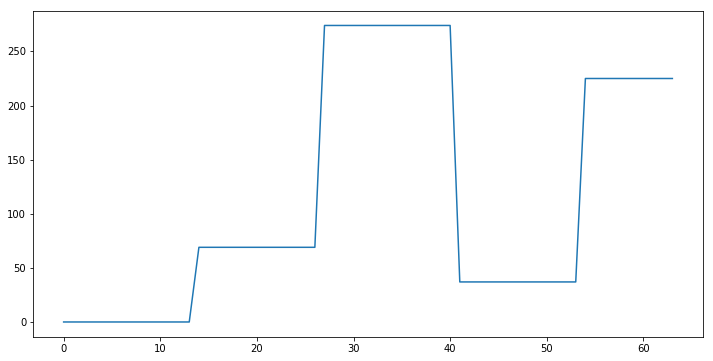

In [31]:
x_orig_vals = np.linspace(0, 1, 64)
freq = 2.17**2
x_vals = x_orig_vals * freq

grid_left = np.floor(x_vals)
grid_right = grid_left + 1

grad_left = hash_func_1d(grid_left)
grad_right = hash_func_1d(grid_left)

plt.plot(grad_left)

(128, 2) (128,)


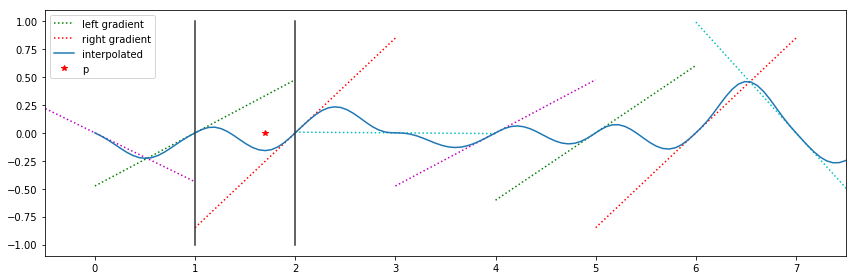

In [170]:
point_to_evaluate = 1.7

def plot_gradients_1d(size, outfile=None):
	grid_pts = np.arange(0, size)
	hashes = hash_func_1d(grid_pts)

	color_wheel = [
		'm:',
		'g:',
		'r:',		
		'c:',
	]
	
	grads = perlin_gradients_edu[hashes % perlin_gradients.shape[0]]

	x_pts = np.linspace(0, size, size*16)
	grid_left = np.floor(x_pts)
	grid_right = grid_left + 1
	x_relative = np.mod(x_pts, 1)
	
	grad_left = perlin_gradients_edu[hash_func_1d(grid_left) % perlin_gradients.shape[0]]
	grad_right = perlin_gradients_edu[hash_func_1d(grid_right) % perlin_gradients.shape[0]]
	
	print(grad_left.shape, x_relative.shape)
	
	noise_vals = mix(
		x_relative*grad_left[:, 0],
		(x_relative-1)*grad_right[:, 0],
		blend_weight_poly(x_relative),
	)
	
	
	fig, plot = plt.subplots(1, figsize=(12, 4))
	
# 	plot.plot([-1, size+1], [0, 0], color=(0.6, 0.6, 0.6))
	
	labels = {
		1: 'left gradient',
		2: 'right gradient',
	}
	
	for idx, grid_pt, grad in zip(range(size), grid_pts, grads):
		plot.plot(
			[grid_pt-1, grid_pt+1], 
			[grad[0]*(-1), grad[0]*1],
			color_wheel[idx % color_wheel.__len__()],
			label=labels.get(idx, None)
		)
	
	plot.plot(x_pts, noise_vals, label="interpolated")
	
	
	
	plot.add_line(mlines.Line2D([1, 1], [-1, 1], color=(0.2, 0.2, 0.2)))
	plot.add_line(mlines.Line2D([2, 2], [-1, 1], color=(0.2, 0.2, 0.2)))
	
	plot.plot([point_to_evaluate], [0], 'r*', label="p")
	
	plot.set_xlim(-0.5, size-0.5)
	handles, labels = plot.get_legend_handles_labels()
	plot.legend(handles, labels)
	
	fig.tight_layout()
	
	if outfile:
		fig.savefig(outfile+'.svg')
		fig.savefig(outfile+'.pdf')
	



plot_gradients_1d(8, 'perlin_gradients_1d')


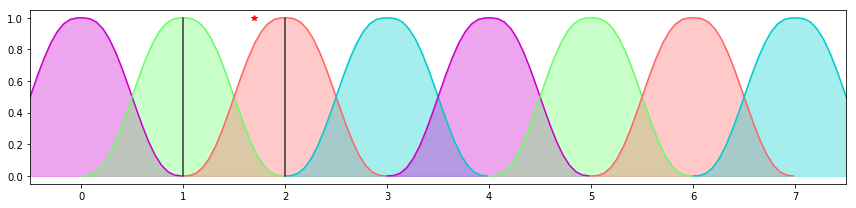

In [167]:
def plot_gradient_weights_1d(size, outfile=None):
	grid_pts = np.arange(0, size)
	hashes = hash_func_1d(grid_pts)

	color_wheel = [
		(0.8, 0.0, 0.8, 0.35),
		(0.4, 1.0, 0.4, 0.35),
		(1.0, 0.4, 0.4, 0.35),
		(0.0, 0.8, 0.8, 0.35),
	]

	pts_x = np.linspace(-1, 0.98, 32)
# 	pts_x = np.concatenate((pts_x, pts_x[::-1]))
	
	pts_weights = blend_weight_poly(
		pts_x - np.floor(pts_x)
	)
	
	positive = pts_x > 0
	pts_weights[positive] = 1-pts_weights[positive] 
	
	fig, plot = plt.subplots(1, figsize=(12, 3))
	
	grads = perlin_gradients_edu[hashes % perlin_gradients.shape[0]]
	for idx, grid_pt, grad in zip(range(size), grid_pts, grads):
		plot.plot(
			pts_x + grid_pt,
			pts_weights,
			color=color_wheel[idx % color_wheel.__len__()][:3],
		)
		plot.fill_between(
			pts_x + grid_pt,
			pts_weights,
			color=color_wheel[idx % color_wheel.__len__()],
		)
		
	plot.set_xlim(-0.5, size-0.5)
	
	fig.tight_layout()
	
	plot.add_line(mlines.Line2D([1, 1], [0, 1], color=(0.2, 0.2, 0.2)))
	plot.add_line(mlines.Line2D([2, 2], [0, 1], color=(0.2, 0.2, 0.2)))
	
	plot.plot([point_to_evaluate], [1], 'r*')
	
	if outfile:
		fig.savefig(outfile+'.svg')
		fig.savefig(outfile+'.pdf')

plot_gradient_weights_1d(8, 'perlin_weights_1d')

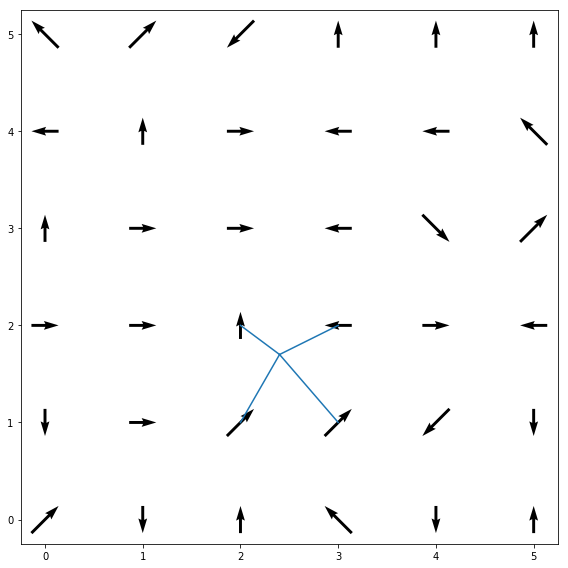

In [121]:

def plot_gradients_2d(size, outfile=None):
	grid = build_grid([size, size], b_norm=False)
	
	grid_flat = grid.reshape(-1, 2)
# 	print(grid_flat)
	hashes = hash_func(grid_flat)
	
	grads = perlin_gradients[hashes % perlin_gradients.shape[0]]
	
	grads = grads * 0.5
	
	fig, plot = plt.subplots(1, figsize=(8, 8))
		
	plot.quiver(
		grid_flat[:, 0], grid_flat[:, 1], 
		grads[:, 0], grads[:, 1],
		pivot='mid',
 		units='x',
		width=0.03,
		scale=1.8,
	)
	
	pt = np.array([2.4, 1.7])
	offsets = np.array([
		[0, 0],
		[1, 0],
		[1, 1],
		[0, 1],
	])
	pt_bl = np.floor(pt)
	
	for of in offsets:
		seg = np.array([pt, pt_bl+of])
		l = mlines.Line2D(seg[:, 0], seg[:, 1])
		plot.add_line(l)
	

	fig.tight_layout()
	
	if outfile:
		fig.savefig(outfile+'.svg')
		fig.savefig(outfile+'.pdf')
	
plot_gradients_2d(6, 'perlin_gradients_2d')